#Objective
**I want to quantitatively compare the results when determining flow from the raw intensity data, and from the relative fluorescence data. I will make a contrived testing scenario where the exact flow is known and compare the approximated flow determined in both approaches.**

###Introduction and Routines

In [7]:
from numpy import *
set_printoptions(1)

def makeData(dim=21, thickness=5, outside=1.0, inside=10.0, calciumAmplitude=50, noise=8.0):
    
    f = zeros((dim,dim,dim))
    fx = zeros((dim-1,dim,dim))
    fy = zeros((dim-1,dim,dim))
    wall1 = dim/2 - thickness/2; wall2 = wall1 + thickness
    f[:,:,:wall1] = outside
    f[:,:,wall1:wall2] = inside
    f[:,:,wall2:] = outside
    for i,frame in enumerate(f[:-2]):
        frame[i:i+3,wall1:wall2] = calciumAmplitude
        fy[i,i:i+3,wall1:wall2] = 1.0
    fy[-1,-2:,wall1:wall2] = 1.0
    f[-2,-2:,wall1:wall2] = calciumAmplitude; f[-1,-1:,wall1:wall2] = calciumAmplitude
    f += random.random((dim,dim,dim))*noise-noise/2
    
    return (f, fx, fy)

In [8]:
import cv2

def calcFlow(dataset, parameters=None):
    flowParams = {'pyr_scale':0.5, 'levels':3, 'winsize':7, 'iterations':3, 'poly_n':5,
                  'poly_sigma':1.1, 'flags':cv2.OPTFLOW_FARNEBACK_GAUSSIAN}
    flowParams = parameters if parameters else flowParams
    frames, h, w = dataset.shape
    yflow = ndarray((frames-1,h,w))
    xflow = ndarray((frames-1,h,w))
    prev = dataset[0]
    for i,curr in enumerate(dataset[1:]):
        flow = cv2.calcOpticalFlowFarneback(prev, curr, **flowParams)
        xflow[i] = flow[:,:,0]
        yflow[i] = flow[:,:,1]
        prev = curr
        
    return (xflow, yflow)

Now we make a routine, *show*, to visualize the flow. It can handle any number of flow fields and allows plotting them in a grid for easier comparison. You can also look at subsets of larger slices using the **frames** parameter. **cols** controls the number of columns used in the grid to display the plots

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show(dataset, xvecs, yvecs, frames=[0,None], cols=3, parameters=None):
    vecParams = {'pivot':'middle', 'angles':'xy', 'scale_units':'xy', 'color':'yellow', 'scale':1}
    vecParams = parameters if parameters else vecParams

    if dataset.ndim == 2:
        plt.figure(figsize=(10,10))
        plt.imshow(dataset, cmap='gray')
        plt.quiver(xvecs, yvecs, **vecParams)
        return
    else:
        begf, endf = frames
        endf = endf if endf else len(xvecs)
        rows = int(ceil((endf-begf)/float(cols)))
        fw = 13; fh = float(rows*fw)/cols
        plt.figure(figsize=(fw, fh))
        for i in range(begf, endf):
            plt.subplot(rows,cols,i-begf+1) 
            plt.imshow(dataset[i], cmap='gray', interpolation='nearest')
            plt.title("Flow from frame %d to frame %d" % (i,i+1))
            plt.quiver(xvecs[i], yvecs[i], **vecParams)
    plt.tight_layout()

####The Error

1. First I determine the L2 norm of the difference between every respective flow vector in the entire spatial and temporal dataset. Essentially it is the point wise error between every flow vector.
2. Then I calculate the Frobenius norm of the matrix for each point in time. The Frobenius norm is simply the square root of the sum of squares of every component, sort of like an L2 norm for matrices. This produces a 1D array where every element is a single number representing the error at each time step. 
3. Finally, I take the average of these norms to get one sinlge number representing the total error or *General Accuracy* of the method on **this** dataset.

In [10]:
def error(fxTrue, fyTrue, fxApprox, fyApprox):

    trueNorms = sqrt(fxTrue**2 + fyTrue**2)
    approxNorms = sqrt(fxApprox**2 + fyApprox**2)
    maxErr = trueNorms+approxNorms
    maxErr[abs(maxErr) < 1e-12] = 1.0
    err = sqrt((fxTrue-fxApprox)**2 + (fyTrue-fyApprox)**2)/maxErr
    print "Maximum Point-wise Error = ", err.max()
    print "Minimum Point-wise Error = ", err.min()
    frob = linalg.norm(err,'fro',(1,2))
    print "Maximum Frobenius Norm = ", frob.max()
    print "Minimum Frobenius Norm = ", frob.min()
    totErr = average(frob)
    print "Total Error = ", totErr
    return totErr

---
###Test 1
Look at relative calcium concentrations...

In [18]:
f, fx, fy = makeData(dim=21, thickness=5, outside=1.0, inside=10.0, calciumAmplitude=50, noise=8.0)

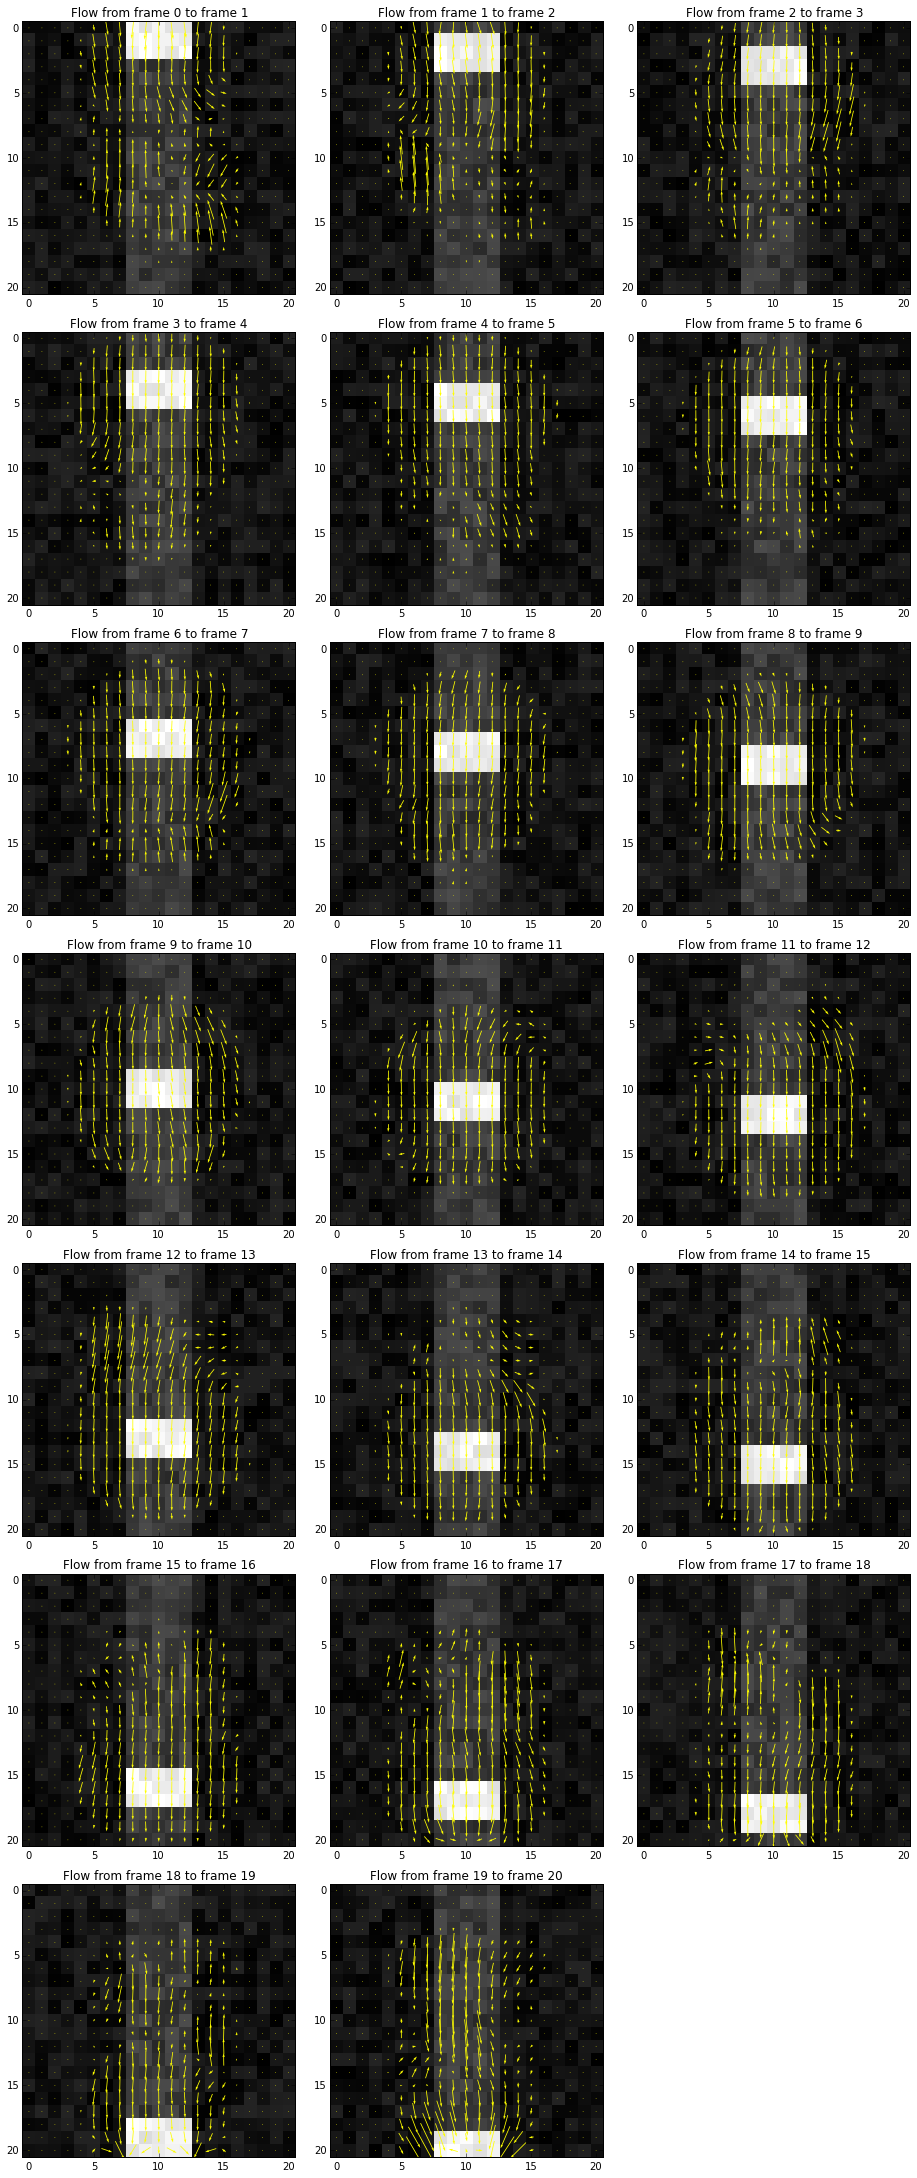

In [19]:
fx1, fy1 = calcFlow(f)
show(f, fx1, fy1)

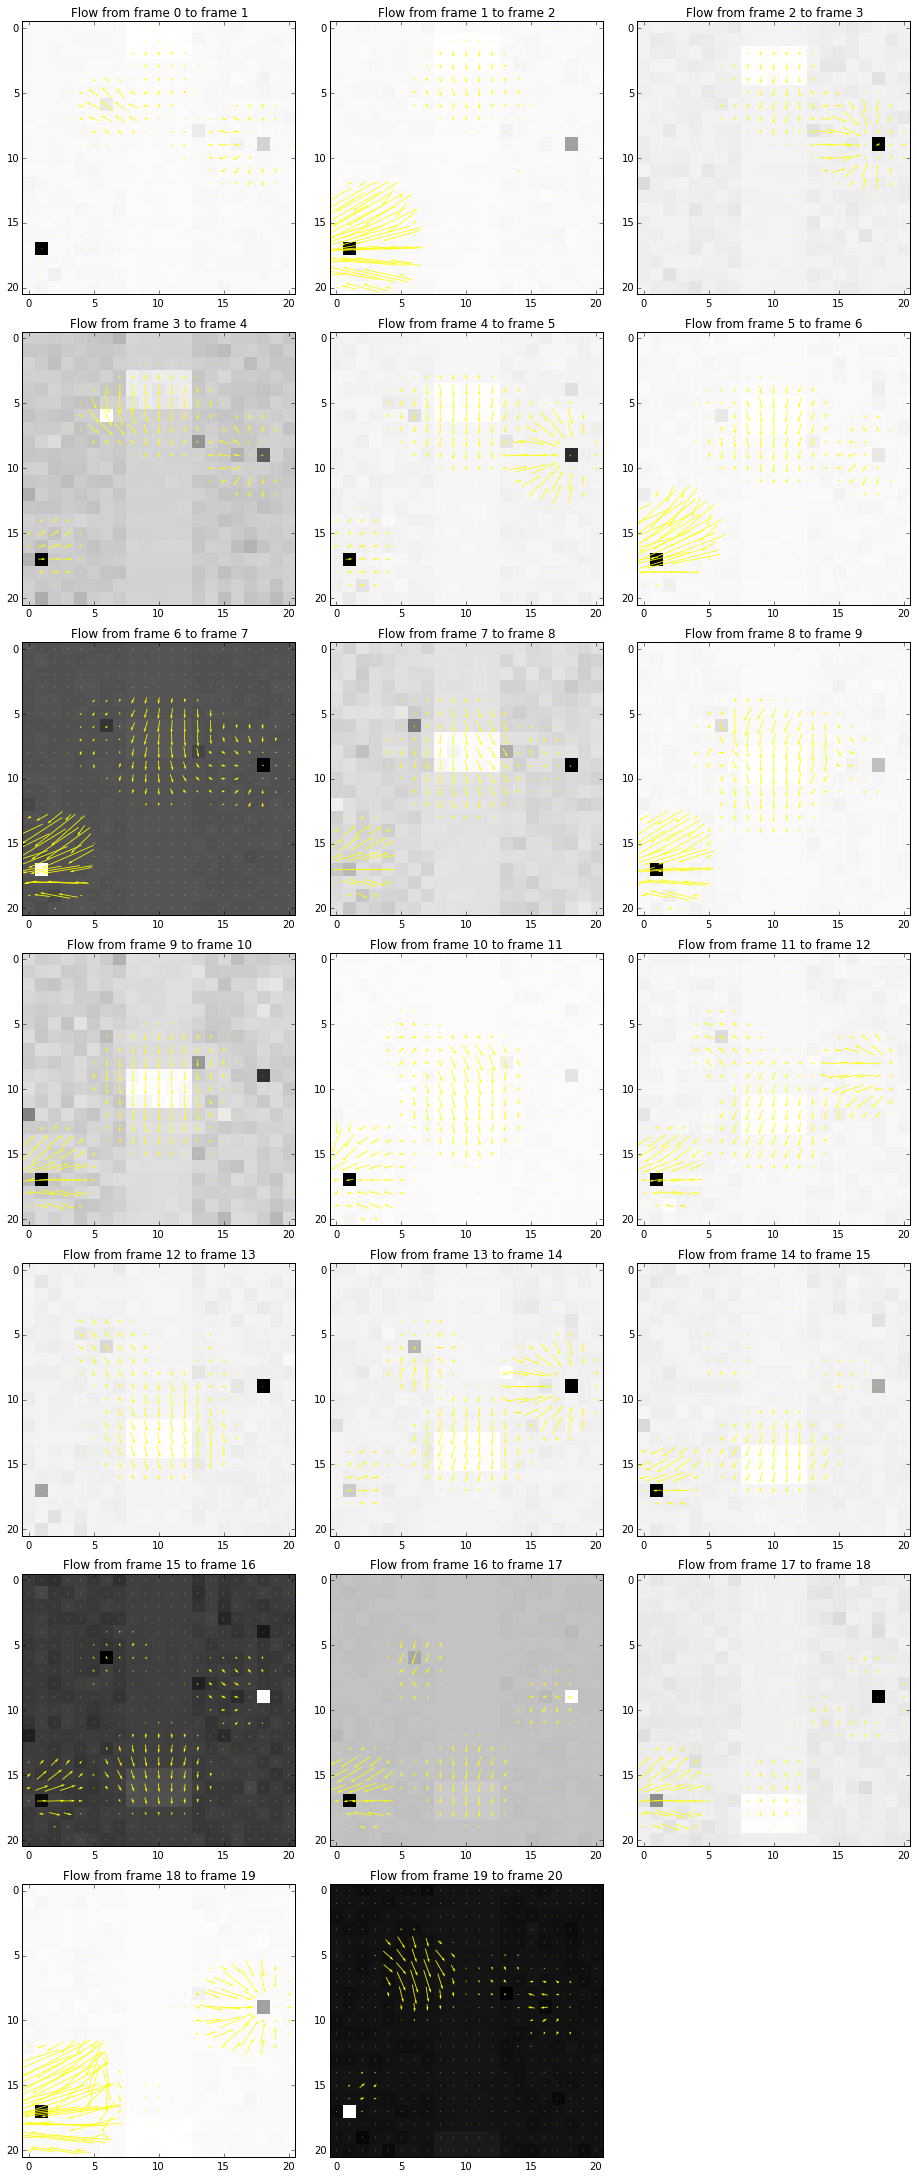

In [20]:
f0 = percentile(f,10,0)
relF = (f-f0)/f0
fx2, fy2 = calcFlow(relF)
show(relF, fx2, fy2)